In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import warnings
from wafer_plot import draw_wafer_plot

warnings.filterwarnings('ignore')

In [2]:
def get_single_ret_loss(wavel, trans, count):
    circ_trans = [] # transmission at 1310 nm
    
    for i, n in enumerate(count):
        x = np.array(wavel[i])
        y = np.array(trans[i])
        circ_trans.append(get_center_loss(x, y))

    coefs = poly.polyfit(count, circ_trans, 1)
    ffit = poly.Polynomial(coefs)
    new_len = np.arange(0.1, 12.5, 0.1)
    loss = -coefs[1]

    # # plot the fitting
    # new_count = np.arange(1, count[-1], 1)
    # fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # ax.plot(count, circ_trans, 'o', markersize=5)
    # ax.plot(new_count, ffit(new_count), '--')
    # ax.set_xlabel('Device count')
    # ax.set_ylabel('Transmission (dB)')
    
    return loss

def get_center_loss(x, y) -> float:
    coefs = poly.polyfit(x, y, 15)
    ffit = poly.Polynomial(coefs) 
    
    # # plot the fitting
    # fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    # ax.plot(x, y, 'o', markersize=5)
    # ax.plot(x, ffit(x), '--')  # x must be a numpy array
    # ax.set_xlabel('Wavelength (nm)')
    # ax.set_ylabel('Transmission (dB)')
    
    return ffit(1310)

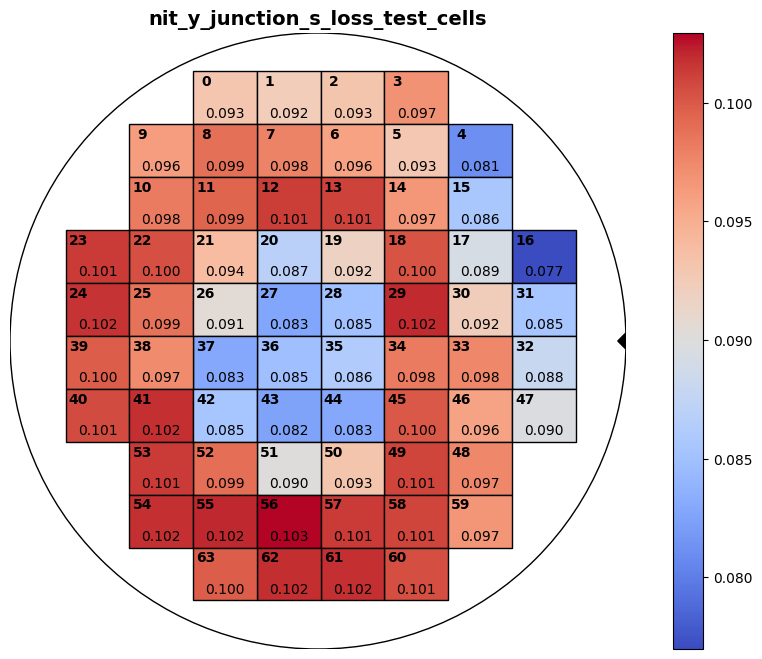

In [22]:
p_current = Path().resolve().parent
root = p_current / 'results' / 'BO_wafer3_data' / 'nit_y_junction_s_loss_test_cells_BO_wafer3'
losses = {}

data_dir_gen = sorted(root.glob('reticle*/*.json'))
for d in data_dir_gen:
    df = pd.read_json(d)
    ret = int(df['reticle'][0])

    wavel = df['wavelength']
    trans = df['transmission_ch1']
    # count = dict(df['n']) # crossing
    count = dict(df['n_junc']) # y-junction
    
    single_ret_loss = get_single_ret_loss(wavel, trans, list(count.values()))
    losses[ret] = single_ret_loss

# print(losses)

# widths = [0.6, 0.8, 1.0, 1.5, 2.0]
# for i, w in enumerate(widths):
#     loss = {ret: l[i] for ret, l in losses.items()}
#     with open(root / f'loss_{w}um.json', 'w') as fp:
#         json.dump(loss, fp)

# get a wafer plot
draw_wafer_plot(data=losses, title=df['test_cell'][0])

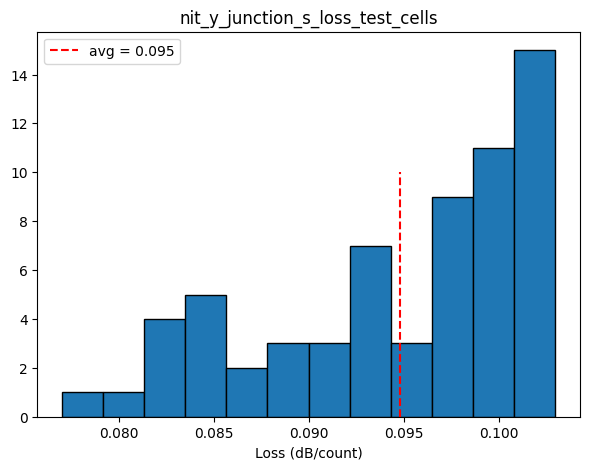

In [23]:
# Plot histograms
loss_values = list(losses.values())
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.hist(loss_values, bins=12, edgecolor='k')
l_avg = np.average(loss_values)
ax.vlines(l_avg, 0, 10, 'r', '--', label=f'avg = {l_avg:.3f}')
ax.set_xlabel('Loss (dB/count)')
ax.set_title(df['test_cell'][0])
ax.legend()

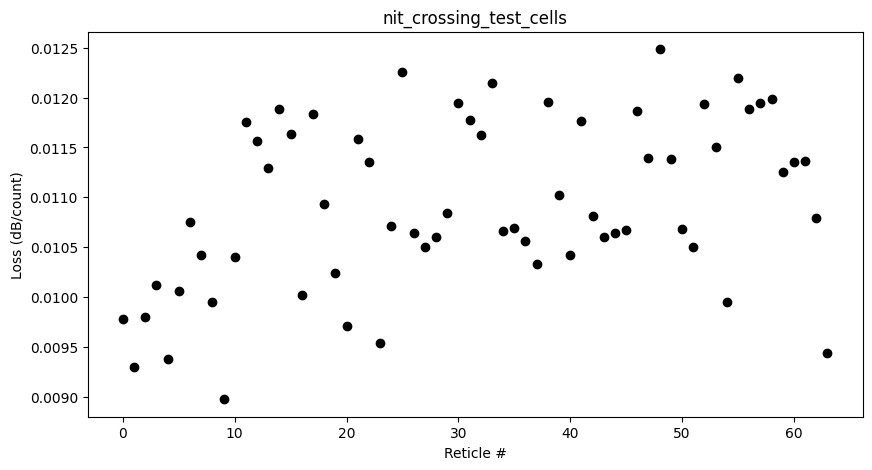

In [16]:
# Create a scattering plot
sorted_dict = {key:losses[key] for key in sorted(losses.keys())}
ret_key = list(sorted_dict.keys())[::1]
fitted_loss = list(sorted_dict.values())[::1]

fig, ax = plt.subplots(1, 1, figsize=[10, 5])
ax.scatter(ret_key, fitted_loss, color='k')
ax.set_title(df['test_cell'][0])
ax.set_xlabel('Reticle #')
ax.set_ylabel('Loss (dB/count)')
# ax.set_ylim([-18.4, -15.8])
plt.show()